# R package

This notebook shows an example of usage of the package that implements the methodolgy to fit and summarise compensators of counting processes described in [...], using a toy dataset.

First we show how to execute the whole pipeline all at once. Then we show and we explore deeper each step.

In [1]:
options(repr.plot.width=6, repr.plot.height=3.5)

In [2]:
source('../iecp/R/reformat_dataset.R')
source('../iecp/R/cross_validation.R')
source('../iecp/R/baseline_hazard.R')
source('../iecp/R/cumulative_hazards.R')
source('../iecp/R/martingale_residuals.R')
source('../iecp/R/fpca.R')

Loading required package: data.table
Loading required package: survival
Loading required package: cobs
Loading required package: latex2exp
Loading required package: splines
Loading required package: ggplot2
Loading required package: foreach
Loading required package: doParallel
Loading required package: iterators
Loading required package: parallel
Loading required package: dplyr

Attaching package: ‘dplyr’

The following objects are masked from ‘package:data.table’:

    between, first, last

The following objects are masked from ‘package:stats’:

    filter, lag

The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union



In [3]:
# load input data; it may contain a "special" column called "mark"
load('input_raw.RData')
head(input_raw)

id,time_event,feature1,feature2,mark,status
1,32.39384,1,72,56,1
1,61.24204,1,72,56,1
1,70.18867,1,72,56,1
1,81.70957,1,72,14,1
1,99.47481,1,72,56,1
1,116.02981,1,72,112,1


## Parameters

In [4]:
# list of possible features combinations
list_features_models = c(
    'feature1 + feature2',
    'Nm + feature1 + feature2',
    'Nm + y + Nm:y + feature1 + feature2'
)

# cross-validation parameter
n_folds = 5
seed = 140
shuffle_ids = TRUE

# fpca parameters
min_explained_variance = 0.99

# All at once: from input data to FPCA output

In [5]:
# add "start", "stop" and "Nm" columns; it also adds a "y" column if a column 'mark' is present in input; 
input = reformat_dataset(input_raw)
# cross validate the list of models and choose the best one in terms of mean absolute Martingale residuals
model = fit_best_recurrent_cox_model(input,list_features_models,n_folds, seed, shuffle_ids)
# fit and smooth the cumulative baseline hazard
smoothed_baseline = fit_smooth_baseline(model)
# reconstruct the compensators
cumulative_hazard = compute_cumulative_hazard(model,input,smoothed_baseline)
# compute FPCA scores
output = compute_fpca_scores(cumulative_hazard,min_explained_variance)

head(output)

id,PC1,PC2
1,8.8662395,0.1347835
2,-0.6052096,3.9855214
3,13.7195168,-2.6571861
4,-20.3748532,2.2414190
5,11.5030229,-1.3082702
6,-14.4230415,3.9794781


# Step by Step

Now we show the output of each of the previous performed steps. 

This is more natural, since we should check the baseline, observe the residuals, the principal components, etc.

## Prepare data

In [6]:
input = reformat_dataset(input_raw, verbose = TRUE)
head(input)

[1] "Adding new columns: start,stop, Nm [N_i(t-)], y [sum of past marks, if mark column is present]"
  |======================================================================| 100%


id,start,stop,status,feature1,feature2,Nm,y
1,0.00000,32.39384,1,1,72,0,0
1,32.39384,61.24204,1,1,72,1,56
1,61.24204,70.18867,1,1,72,2,112
1,70.18867,81.70957,1,1,72,3,168
1,81.70957,99.47481,1,1,72,4,182
1,99.47481,116.02981,1,1,72,5,238


## Cross Validation

In [7]:
model = fit_best_recurrent_cox_model(input,list_features_models,n_folds, seed, shuffle_ids, verbose = TRUE)

[1] "Cross validating formula: Surv(start,stop,status)~ feature1 + feature2 + cluster(id)"
  |======================================================================| 100%
[1] "Cross validating formula: Surv(start,stop,status)~ Nm + feature1 + feature2 + cluster(id)"
  |======================================================================| 100%
[1] "Cross validating formula: Surv(start,stop,status)~ Nm + y + Nm:y + feature1 + feature2 + cluster(id)"
  |======================================================================| 100%


[1] "****************** Cross validation mean absolute Martingale residual ******************"

[1] "|------------------------|--------------------------------------|"
[1] "|   MEAN ABS. RESIDUAL   |               FORMULA                |"
[1] "|------------------------|--------------------------------------|"
[1] "|        0.362           |  feature1 + feature2                  <------ BEST MODEL"
[1] "|        0.55           |  Nm + feature1 + feature2"
[1] 

## Compute and smooth baseline Hazards

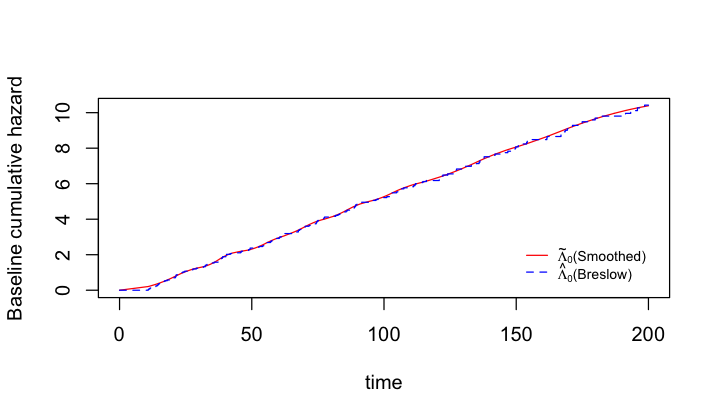

In [8]:
smoothed_baseline = fit_smooth_baseline(model)
plot_baseline_hazard(model,smoothed_baseline)

## Reconstruct patients cumulative Hazards

In [9]:
start_time <- Sys.time()
cumulative_hazard = compute_cumulative_hazard(model,input,smoothed_baseline,verbose = TRUE)
end_time <- Sys.time()

end_time - start_time


[1] "Computing coefficients ck = exp{beta*x_i(t_k)}"
  |======================================================================| 100%
[1] "Computing cumulative Hazard on the grid"
  |======================================================================| 100%


Time difference of 3.713259 secs

In [10]:
#cumulative_hazard
cumulative_hazard = compute_cumulative_hazard(model,input,smoothed_baseline,verbose = TRUE)
head(cumulative_hazard)

[1] "Computing coefficients ck = exp{beta*x_i(t_k)}"
  |======================================================================| 100%
[1] "Computing cumulative Hazard on the grid"
  |======================================================================| 100%


id,time,cumhaz
1,10.83621,0.1657357
1,11.83621,0.1977364
1,12.83621,0.2325600
1,13.83621,0.2702064
1,14.83621,0.3106758
1,15.83621,0.3539680


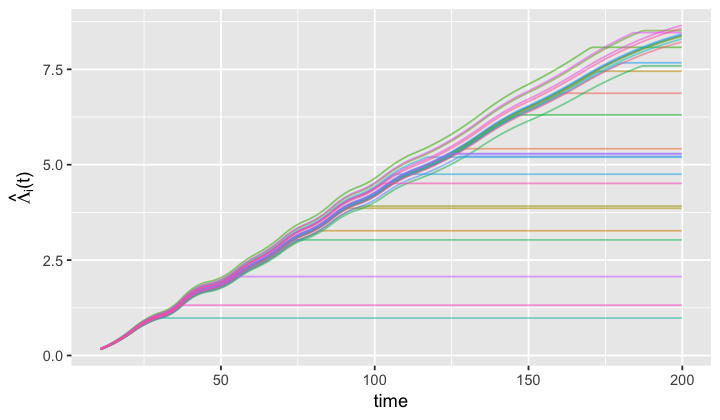

In [11]:
plot_cumulative_hazard(cumulative_hazard)

## Compute martingale residuals

In [12]:
residuals = get_residuals(input,cumulative_hazard, verbose = TRUE)
head(residuals)

  |======================================================================| 100%


id,time,cumhaz,Nt,residuals
1,10.83621,0.1657357,0,0.1657357
1,11.83621,0.1977364,0,0.1977364
1,12.83621,0.2325600,0,0.2325600
1,13.83621,0.2702064,0,0.2702064
1,14.83621,0.3106758,0,0.3106758
1,15.83621,0.3539680,0,0.3539680


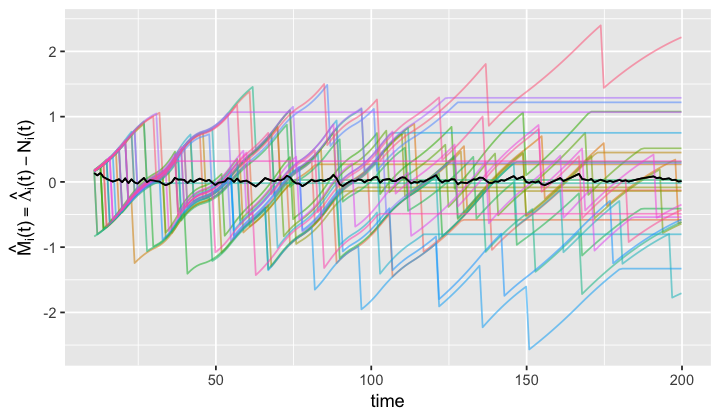

In [13]:
plot_martingale_residuals(residuals)

## FPCA

In [16]:
head(cumulative_hazard)

id,time,cumhaz
1,10.83621,0.1657357
1,11.83621,0.1977364
1,12.83621,0.2325600
1,13.83621,0.2702064
1,14.83621,0.3106758
1,15.83621,0.3539680


  |======================================================================| 100%
[1] "To explain 99 % of the variability 2 components are needed."


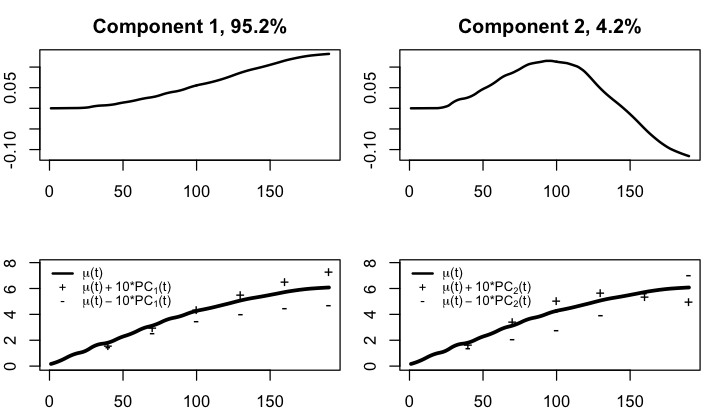

In [14]:
output = compute_fpca_scores(cumulative_hazard,min_explained_variance,plot_eigenfunctions = TRUE,verbose = TRUE)

In [15]:
head(output)

id,PC1,PC2
1,8.8662395,0.1347835
2,-0.6052096,3.9855214
3,13.7195168,-2.6571861
4,-20.3748532,2.2414190
5,11.5030229,-1.3082702
6,-14.4230415,3.9794781
